# Importações

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Definição da rede neural

## funções úteis

In [4]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [5]:
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [17]:
def plot_image(image):
    image = image.reshape((28, 28))

    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

## definição da classe

In [6]:
class Network(object):
    def __init__(self, sizes) -> None:
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    
    def __call__(self, a):
        pred = self.feedforward(a)

        greater = pred[0]
        greater_index = -1
        index = 0

        for x in pred:
            if (x > greater):
                greater = x
                greater_index = index
            
            index += 1
        
        return greater_index

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        training_data = list(training_data)

        if (test_data): test_data = list(test_data)

        if (test_data): n_teste = len(test_data)

        n = len(training_data)

        for j in range(epochs):
            random.shuffle(training_data)

            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]

            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            if (test_data):
                print("Epoch {0}: {1}/  {2}".format(j, self.evaluate(test_data), n_teste))
            else:
                print("Epoch {0} complete".format(j))
        
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        self.weights = [w - (eta / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]
    
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x] 
        zs = [] 
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

# Utilização

## importações

In [7]:
import mnist_loader

## Treinando o modelo

Instanciando o modelo

In [8]:
model = Network([784, 30, 10])

Importando os dados para treino

In [23]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

Executando o gradiente descendente estocástico

In [11]:
model.SGD(training_data, 30, 10, 3, test_data)

Epoch 0: 9003/  10000
Epoch 1: 9210/  10000
Epoch 2: 9216/  10000
Epoch 3: 9284/  10000
Epoch 4: 9268/  10000
Epoch 5: 9376/  10000
Epoch 6: 9388/  10000
Epoch 7: 9403/  10000
Epoch 8: 9425/  10000
Epoch 9: 9428/  10000
Epoch 10: 9427/  10000
Epoch 11: 9431/  10000
Epoch 12: 9469/  10000
Epoch 13: 9449/  10000
Epoch 14: 9478/  10000
Epoch 15: 9472/  10000
Epoch 16: 9495/  10000
Epoch 17: 9513/  10000
Epoch 18: 9468/  10000
Epoch 19: 9464/  10000
Epoch 20: 9477/  10000
Epoch 21: 9502/  10000
Epoch 22: 9504/  10000
Epoch 23: 9487/  10000
Epoch 24: 9491/  10000
Epoch 25: 9484/  10000
Epoch 26: 9470/  10000
Epoch 27: 9497/  10000
Epoch 28: 9504/  10000
Epoch 29: 9483/  10000


## Validando o modelo

In [35]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [36]:
first_image_vd = list(validation_data)[578][0]

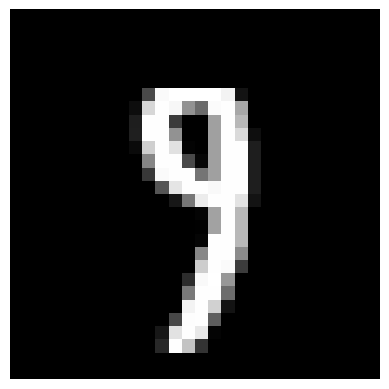

In [37]:
plot_image(first_image_vd)

In [38]:
model(first_image_vd)

9